#### import numpy and pandas

In [1]:
import numpy as np
import pandas as pd


#### download wiki data parsing Not Assigned values as a null value

In [2]:
df = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M", flavor ='bs4',na_values='Not assigned' )

In [3]:
data =df[0]
data.shape

(180, 3)

#### drop na values in essence values initially tagged Not Assigned

In [4]:
data.dropna(axis =0, how='any', subset=['Borough'], inplace=True)

In [5]:
data.shape

(103, 3)

##### Due to the unreliability and constant problems faced with geopy and geocoder pankage, the latitude and longitude  data are downloaded from http://cocl.us/Geospatial_data

In [6]:
import wget
wget.download('http://cocl.us/Geospatial_data', 'latlng.csv')
dx = pd.read_csv('latlng.csv')

100% [................................................................................] 2891 / 2891

In [7]:
dx.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


##### Next step is to merge the location data with the wiki data obtained initially

In [12]:
data_merged = dx.merge(data, how='inner', on ='Postal Code')
data_merged = data_merged[['Postal Code','Borough','Neighborhood','Latitude','Longitude']]

In [14]:
data_merged.head(10)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


#### <p style="text-align:center"><u>Visualizing The distribution of our Locations on the map</u></p>
##### Let's create a folium map to visualize the position of our locations on a map of toronto , Canada.
##### First, we import the Nominatim api from the geocoders package to obtain the latitude and longitude of toronto , Then we create map using folium by pinning all  locations from our location data onto the map.

In [16]:
from geopy.geocoders import Nominatim
address = 'TORONTO, CANADA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print ("The geographical coordinate of Toronto are {} {}.".format(latitude, longitude))

The geographical coordinate of Toronto are 43.6534817 -79.3839347.


In [20]:
import folium

toronto_map = folium.Map(location = [latitude,longitude], zoom_start=11)

for lat,lng  in zip(data_merged['Latitude'], data_merged['Longitude']):
    folium.CircleMarker(location=[lat,lng],
                       radius =2,
                       color ='blue',
                       fill = True,
                       fill_color = 'white').add_to(toronto_map)
toronto_map

##### The map above shows a distribution of Neighborhoods in Toronto. Canada.

#### The next task is to make use of the foursquare api to collect data on Neighborhoods in Toronto based on the category of venues in each vicinity.

In [21]:
# we input our foursquare api account details 
CLIENT_ID = '2SMPYAP4DVDSG52DG15QP3ZWC3KGGY5CQW4RSLDMEIF1PMY4' # your Foursquare ID
CLIENT_SECRET = 'F0PNOYP5QALSRQW1URNG4KNDDYIEQOUDAVZWOIJO2QTH2EUH' # your Foursquare Secret
VERSION = '20200505' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2SMPYAP4DVDSG52DG15QP3ZWC3KGGY5CQW4RSLDMEIF1PMY4
CLIENT_SECRET:F0PNOYP5QALSRQW1URNG4KNDDYIEQOUDAVZWOIJO2QTH2EUH


In [26]:
#import requests to make api calls via the foursquare api
import requests


#### Lets define a function to obtain nearby venues using the foursquare api for each neighborhood appending each collection into a pandas dataframe

In [38]:
def get_nearby_venues(names, postal_code,latitudes, longitudes, radius=1100):
    venues_list=[]
    LIMIT =130
    for name,pc, lat, lng in zip(names, postal_code,latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
               
        venues_list.append([(
            name, 
            pc,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                             'Postal Code',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
        

In [39]:
toronto_venues = get_nearby_venues(names=data_merged['Neighborhood'],
                                   postal_code=data_merged['Postal Code'],
                                   latitudes=data_merged['Latitude'],
                                   longitudes=data_merged['Longitude']
                                  )


#### Our snippet of our data 

In [40]:
toronto_venues.head(10)

,Neighborhood,Postal Code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",M1B,43.806686,-79.194353,Harvey's,43.800020,-79.198307,Restaurant
1,"Malvern, Rouge",M1B,43.806686,-79.194353,Wendy's,43.802008,-79.198080,Fast Food Restaurant
2,"Malvern, Rouge",M1B,43.806686,-79.194353,RBC Royal Bank,43.798782,-79.197090,Bank
3,"Malvern, Rouge",M1B,43.806686,-79.194353,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant
4,"Malvern, Rouge",M1B,43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
5,"Malvern, Rouge",M1B,43.806686,-79.194353,Staples Morningside,43.800285,-79.196607,Paper / Office Supplies Store
6,"Malvern, Rouge",M1B,43.806686,-79.194353,Tim Hortons,43.802000,-79.198169,Coffee Shop
7,"Malvern, Rouge",M1B,43.806686,-79.194353,Images Salon & Spa,43.802283,-79.198565,Spa
8,"Malvern, Rouge",M1B,43.806686,-79.194353,MMA World Academy,43.800259,-79.195227,Martial Arts Dojo
9,"Malvern, Rouge",M1B,43.806686,-79.194353,Rouge Park - Woodland Trail,43.801782,-79.200427,Trail


#### A careful look at the summary of our data below, we observe some very important information.
- We have been able to gather data of 4893 venues , from 103 Neighborhoods with distinct venue categories 
Next is to prepare our data for Processing . 
It is obvious that we are dealing with categorical variables, this makes it difficult to process, in such case we make use of 
One_hot_encoding using the pd.getdummies() function

In [41]:
toronto_venues.describe(include='all')

,Neighborhood,Postal Code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
count,5421,5421,5421.000000,5421.000000,5421,5421.000000,5421.000000,5421
unique,99,103,NaN,NaN,2983,NaN,NaN,339
top,Don Mills,M5K,NaN,NaN,Tim Hortons,NaN,NaN,Coffee Shop
freq,115,100,NaN,NaN,123,NaN,NaN,423
mean,NaN,NaN,43.686891,-79.391468,NaN,43.686512,-79.391925,NaN
std,NaN,NaN,0.044942,0.068330,NaN,0.044883,0.068099,NaN
min,NaN,NaN,43.602414,-79.615819,NaN,43.592863,-79.626960,NaN
25%,NaN,NaN,43.651571,-79.419750,NaN,43.651296,-79.419491,NaN
50%,NaN,NaN,43.669542,-79.384568,NaN,43.669607,-79.386977,NaN
75%,NaN,NaN,43.711695,-79.360636,NaN,43.708496,-79.359060,NaN


In [198]:
dummy = pd.get_dummies(toronto_venues[['Venue Category']], prefix = "", prefix_sep="")
dummy[["Neighborhood","Postal Code"]] = toronto_venues[['Neighborhood','Postal Code']]

In [199]:
dummy[['Neighborhood','Postal Code']].shape

(5421, 2)

In [242]:
ss = dummy.columns.tolist()
ss.remove('Neighborhood')
ss.insert(0,'Neighborhood')
dummy = dummy[ss]

In [243]:
dummy_grouped = dummy.groupby( ['Neighborhood','Postal Code']).mean().reset_index()

In [244]:
dummy_grouped.head()

,Neighborhood,Postal Code,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,...,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Agincourt,M1S,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.019608,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,"Alderwood, Long Branch",M8W,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",M3H,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,Bayview Village,M2K,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",M5M,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.020833,0.020833,0.0,0.0,0.0


We have sucessfully converted all categorical variables into float values that can be meaningful to our analysis .
As an example let's calculate the most frequent venues in each neighborhood by sorting there mean values in descending order .
We start by writing a function to sort the venues in descending order

In [203]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [204]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood','Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted[['Neighborhood','Postal Code']] = dummy_grouped[['Neighborhood','Postal Code']]
for ind in np.arange(dummy_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 2:] = return_most_common_venues(dummy_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,M1S,Chinese Restaurant,Shopping Mall,Coffee Shop,Pizza Place,Caribbean Restaurant,Bakery,Sandwich Place,Pharmacy,Sri Lankan Restaurant,Noodle House
1,"Alderwood, Long Branch",M8W,Hotel,Park,Grocery Store,Gas Station,Pizza Place,Pharmacy,Coffee Shop,Convenience Store,Dance Studio,Discount Store
2,"Bathurst Manor, Wilson Heights, Downsview North",M3H,Pizza Place,Bank,Coffee Shop,Supermarket,Other Great Outdoors,Dog Run,Ski Chalet,Sandwich Place,Sushi Restaurant,Fried Chicken Joint
3,Bayview Village,M2K,Bank,Gas Station,Japanese Restaurant,Café,Chinese Restaurant,Park,Trail,Restaurant,Grocery Store,Intersection
4,"Bedford Park, Lawrence Manor East",M5M,Coffee Shop,Italian Restaurant,Bagel Shop,Pizza Place,Bank,Restaurant,Sandwich Place,Pharmacy,Juice Bar,Gift Shop
5,Berczy Park,M5E,Coffee Shop,Café,Hotel,Japanese Restaurant,Restaurant,Park,Gastropub,Art Gallery,Liquor Store,Creperie
6,"Birch Cliff, Cliffside West",M1N,Park,College Stadium,Café,Skating Rink,General Entertainment,Thai Restaurant,Gym,Gym Pool,Diner,Ice Cream Shop
7,"Brockton, Parkdale Village, Exhibition Place",M6K,Café,Coffee Shop,Bar,Furniture / Home Store,Restaurant,Bakery,Park,Gift Shop,Supermarket,Tibetan Restaurant
8,"Business reply mail Processing Centre, South C...",M7Y,Indian Restaurant,Park,Pizza Place,Bakery,Coffee Shop,Brewery,Sushi Restaurant,Italian Restaurant,Grocery Store,Beach
9,"CN Tower, King and Spadina, Railway Lands, Har...",M5V,Harbor / Marina,Coffee Shop,Park,Café,Gym,Track,Scenic Lookout,Dog Run,Sculpture Garden,Garden


The table above shows the Frequency of Occurence of Venues in each neighborhood in descending order.
 From the table it is possible to begin to make inferences about each Neighborhood

#### Using the KMeans algorithm 
##### Our Next task is to input our features into the clustering algorithm .


In [205]:
toronto_cluster = dummy_grouped.drop(['Neighborhood','Postal Code'], axis =1)

In [206]:
from sklearn.cluster import KMeans
kclusters = 5

kmeans = KMeans(n_clusters = kclusters, n_init=15).fit(toronto_cluster)
kmeans.labels_.shape

(103,)

#### Let's Create a new dataframe that includes the Cluster as well as the top 10 venues for each neighborhood

In [207]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [208]:
dummy_merge = neighborhoods_venues_sorted
dummy_merge.set_index(['Neighborhood','Postal Code']).head()

,,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,Postal Code,,,,,,,,,,,
Agincourt,M1S,0,Chinese Restaurant,Shopping Mall,Coffee Shop,Pizza Place,Caribbean Restaurant,Bakery,Sandwich Place,Pharmacy,Sri Lankan Restaurant,Noodle House
"Alderwood, Long Branch",M8W,0,Hotel,Park,Grocery Store,Gas Station,Pizza Place,Pharmacy,Coffee Shop,Convenience Store,Dance Studio,Discount Store
"Bathurst Manor, Wilson Heights, Downsview North",M3H,0,Pizza Place,Bank,Coffee Shop,Supermarket,Other Great Outdoors,Dog Run,Ski Chalet,Sandwich Place,Sushi Restaurant,Fried Chicken Joint
Bayview Village,M2K,1,Bank,Gas Station,Japanese Restaurant,Café,Chinese Restaurant,Park,Trail,Restaurant,Grocery Store,Intersection
"Bedford Park, Lawrence Manor East",M5M,4,Coffee Shop,Italian Restaurant,Bagel Shop,Pizza Place,Bank,Restaurant,Sandwich Place,Pharmacy,Juice Bar,Gift Shop


In [221]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = dummy_merge.join(data_merged.set_index(['Neighborhood','Postal Code']),
                                   on=['Neighborhood','Postal Code'])

toronto_merged.head(2) # check the last columns!

,Cluster Labels,Neighborhood,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough,Latitude,Longitude
0,0,Agincourt,M1S,Chinese Restaurant,Shopping Mall,Coffee Shop,Pizza Place,Caribbean Restaurant,Bakery,Sandwich Place,Pharmacy,Sri Lankan Restaurant,Noodle House,Scarborough,43.794200,-79.262029
1,0,"Alderwood, Long Branch",M8W,Hotel,Park,Grocery Store,Gas Station,Pizza Place,Pharmacy,Coffee Shop,Convenience Store,Dance Studio,Discount Store,Etobicoke,43.602414,-79.543484


Removing overlaping columns by intoducing a regex function

In [224]:
toronto_merged.drop(toronto_merged.filter(regex='_x$|_y$').columns.tolist(),axis=1, inplace=True)

#### Creating Our map and displaying cluster category by different colors

In [226]:
import matplotlib.colors as colors
import matplotlib.cm as cm
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#Our Clusters are shown by five distinct colors representing each cluster Labels
['#8000ff', '#00b5eb', '#80ffb4', '#ffb360', '#ff0000']

## Examining Our Clusters

## <p style="text-align:center">Cluster0</p>

In [406]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(3, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough,Latitude,Longitude
0,Agincourt,Chinese Restaurant,Shopping Mall,Coffee Shop,Pizza Place,Caribbean Restaurant,Bakery,Sandwich Place,Pharmacy,Sri Lankan Restaurant,Noodle House,Scarborough,43.794200,-79.262029
1,"Alderwood, Long Branch",Hotel,Park,Grocery Store,Gas Station,Pizza Place,Pharmacy,Coffee Shop,Convenience Store,Dance Studio,Discount Store,Etobicoke,43.602414,-79.543484
2,"Bathurst Manor, Wilson Heights, Downsview North",Pizza Place,Bank,Coffee Shop,Supermarket,Other Great Outdoors,Dog Run,Ski Chalet,Sandwich Place,Sushi Restaurant,Fried Chicken Joint,North York,43.754328,-79.442259
12,Cedarbrae,Coffee Shop,Bakery,Gas Station,Indian Restaurant,Bank,Sandwich Place,Bus Line,Light Rail Station,Sushi Restaurant,Martial Arts Dojo,Scarborough,43.773136,-79.239476
16,"Clarks Corners, Tam O'Shanter, Sullivan",Fast Food Restaurant,Coffee Shop,Bank,Convenience Store,Sandwich Place,Vietnamese Restaurant,Pharmacy,Park,Seafood Restaurant,Caribbean Restaurant,Scarborough,43.781638,-79.304302
17,"Cliffside, Cliffcrest, Scarborough Village West",Ice Cream Shop,Pizza Place,Beach,Harbor / Marina,Hardware Store,Discount Store,Sandwich Place,Park,Grocery Store,Sports Bar,Scarborough,43.716316,-79.239476
21,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",Furniture / Home Store,Fast Food Restaurant,Sandwich Place,Grocery Store,Coffee Shop,Convenience Store,Pharmacy,Gas Station,Bar,Thrift / Vintage Store,York,43.691116,-79.476013
24,"Dorset Park, Wexford Heights, Scarborough Town...",Coffee Shop,Fast Food Restaurant,Pharmacy,Chinese Restaurant,Bank,Bakery,Restaurant,Park,Electronics Store,Indian Restaurant,Scarborough,43.757410,-79.273304
28,Downsview,Hotel,Grocery Store,Gas Station,Coffee Shop,Fast Food Restaurant,Pizza Place,Discount Store,Road,Falafel Restaurant,Liquor Store,North York,43.761631,-79.520999
36,Glencairn,Grocery Store,Fast Food Restaurant,Pizza Place,Coffee Shop,Gas Station,Italian Restaurant,Park,Restaurant,Mediterranean Restaurant,Discount Store,North York,43.709577,-79.445073


#### This view is rather hectic, hence we can make use of a plot to view the composition of Top Venues in Cluster 1.
#### Let's bring back our data and make a barplot of top 20 venues in cluster 0

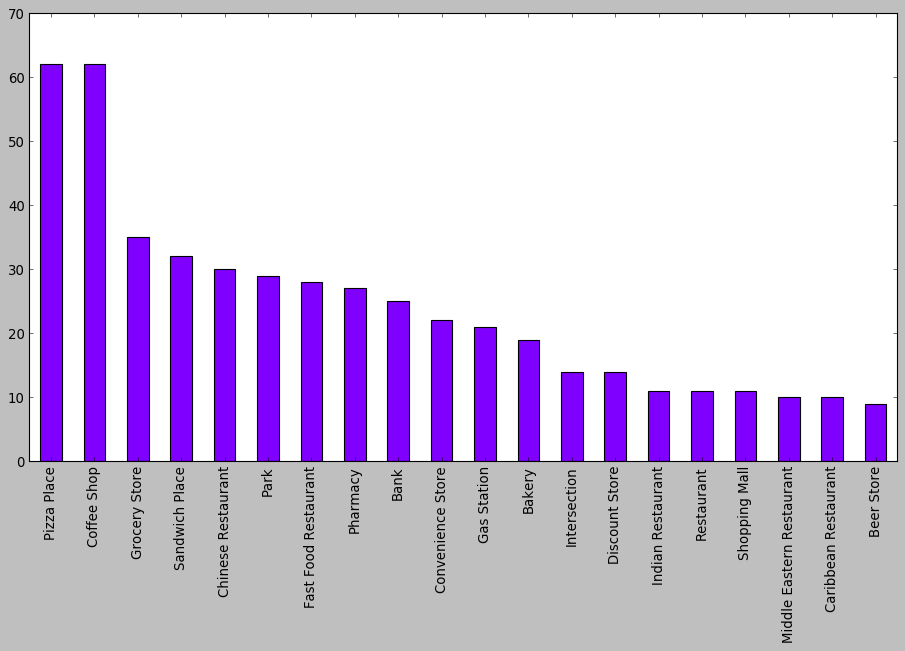

In [519]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('tableau-colorblind10')
fig,ax = plt.subplots()

cluster0 = test.groupby('Cluster Labels').sum().iloc[0]
cluster0_20 = cluster0.sort_values(ascending =False).iloc[:20]

ax0 = cluster0_20.plot(kind='bar', color =rainbow[0], figsize=(14,7))

The above plot of the top 20 venues in Cluster 0, gives us a good overview of the type of neighborhood Cluster0 is.

## <p style="text-align:center">Cluster1</p>
For Cluster 1 with (k=1); We take a look at the top 10 Most Common Venue For each of the Neighborhoods that make up Cluster 1.

In [407]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(3, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough,Latitude,Longitude
3,Bayview Village,Bank,Gas Station,Japanese Restaurant,Café,Chinese Restaurant,Park,Trail,Restaurant,Grocery Store,Intersection,North York,43.786947,-79.385975
6,"Birch Cliff, Cliffside West",Park,College Stadium,Café,Skating Rink,General Entertainment,Thai Restaurant,Gym,Gym Pool,Diner,Ice Cream Shop,Scarborough,43.692657,-79.264848
10,Caledonia-Fairbanks,Pharmacy,Bus Stop,Park,Grocery Store,Portuguese Restaurant,Food & Drink Shop,Food Truck,Mexican Restaurant,Sporting Goods Shop,Fast Food Restaurant,York,43.689026,-79.453512
26,Downsview,Park,Bank,Coffee Shop,Moving Target,Shopping Mall,Vietnamese Restaurant,Pizza Place,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,North York,43.739015,-79.506944
27,Downsview,Vietnamese Restaurant,Grocery Store,Baseball Field,BBQ Joint,Pharmacy,Bank,Turkish Restaurant,Farmers Market,Egyptian Restaurant,Electronics Store,North York,43.728496,-79.495697
41,Hillcrest Village,Pharmacy,Park,Coffee Shop,Middle Eastern Restaurant,Restaurant,Fast Food Restaurant,Cantonese Restaurant,Shopping Mall,Sushi Restaurant,Chinese Restaurant,North York,43.803762,-79.363452
42,Humber Summit,Bakery,Pharmacy,Bank,Electronics Store,Park,Shopping Mall,Furniture / Home Store,Italian Restaurant,Pizza Place,Arts & Crafts Store,North York,43.756303,-79.565963
46,"Islington Avenue, Humber Valley Village",Pharmacy,Convenience Store,Bus Stop,Café,Skating Rink,Shopping Mall,Golf Course,Bank,Grocery Store,Park,Etobicoke,43.667856,-79.532242
58,"New Toronto, Mimico South, Humber Bay Shores",Park,Café,Bakery,Grocery Store,Skating Rink,Fast Food Restaurant,Pharmacy,Fried Chicken Joint,Italian Restaurant,Dessert Shop,Etobicoke,43.605647,-79.501321
63,"Old Mill South, King's Mill Park, Sunnylea, Hu...",Italian Restaurant,Ice Cream Shop,Bus Stop,Shopping Mall,Bank,Eastern European Restaurant,Harbor / Marina,Park,Design Studio,Ethiopian Restaurant,Etobicoke,43.636258,-79.498509


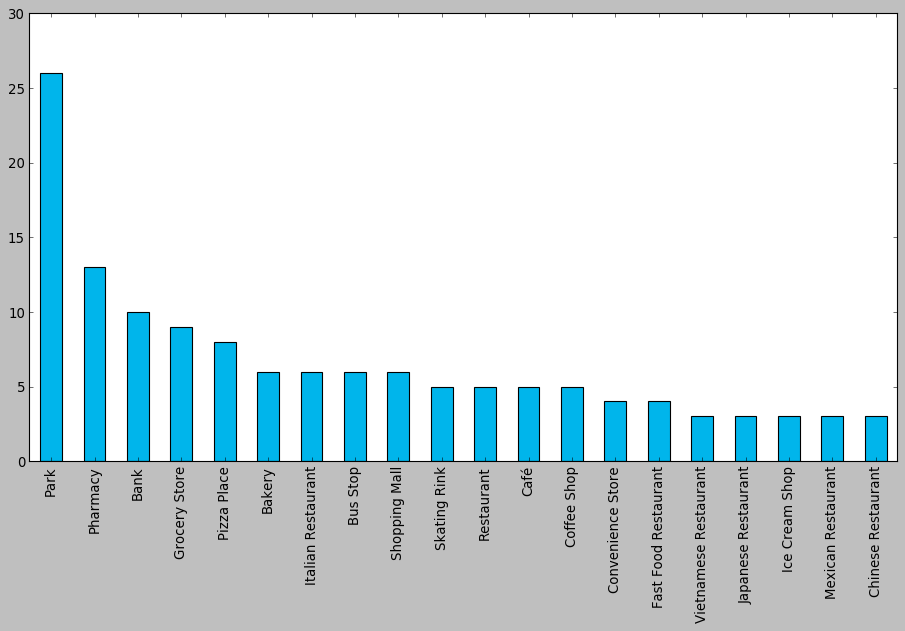

In [518]:
cluster1 = test.groupby('Cluster Labels').sum().iloc[1]
cluster1_20 = cluster1.sort_values(ascending =False).iloc[:20]

ax1 = cluster1_20.plot(kind='bar', color =rainbow[1], figsize=(14,7))

## <p style="text-align:center">Cluster2</p>
For Cluster 2 with (k=2); We take a look at the top 10 Most Common Venue For each of the Neighborhoods that make up Cluster 2.

In [413]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(3, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough,Latitude,Longitude
102,"York Mills, Silver Hills",Park,Gym / Fitness Center,Coffee Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,North York,43.75749,-79.374714


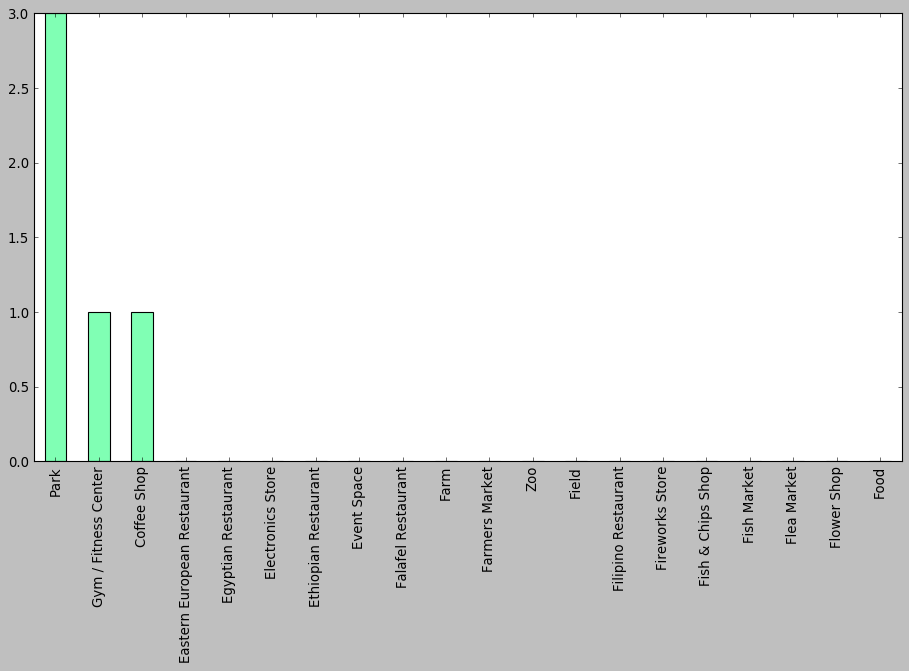

In [517]:
cluster2 = test.groupby('Cluster Labels').sum().iloc[2]
cluster2_20 = cluster2.sort_values(ascending =False).iloc[:20]

ax2 = cluster2_20.plot(kind='bar', color =rainbow[2], figsize=(14,7))

## <p style="text-align:center">Cluster3</p>
For Cluster 3 with (k=3); We take a look at the top 10 Most Common Venue For each of the Neighborhoods that make up Cluster 3.

In [412]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(3, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough,Latitude,Longitude
90,Upper Rouge,Donut Shop,Zoo,Filipino Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Scarborough,43.836125,-79.205636


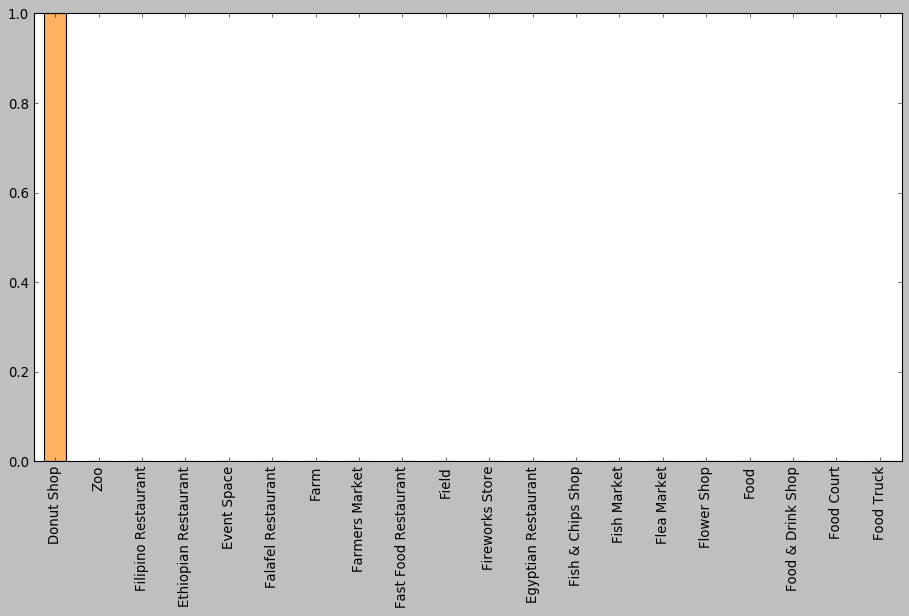

In [516]:
cluster3 = test.groupby('Cluster Labels').sum().iloc[3]
cluster3_20 = cluster3.sort_values(ascending =False).iloc[:20]

ax3 = cluster3_20.plot(kind='bar', color =rainbow[3], figsize=(14,7))

## <p style="text-align:center">Cluster4</p>
For Cluster 4 with (k=4); We take a look at the top 10 Most Common Venue For each of the Neighborhoods that make up Cluster 4.

In [417]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(3, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough,Latitude,Longitude
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Italian Restaurant,Bagel Shop,Pizza Place,Bank,Restaurant,Sandwich Place,Pharmacy,Juice Bar,Gift Shop,North York,43.733283,-79.419750
5,Berczy Park,Coffee Shop,Café,Hotel,Japanese Restaurant,Restaurant,Park,Gastropub,Art Gallery,Liquor Store,Creperie,Downtown Toronto,43.644771,-79.373306
7,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Bar,Furniture / Home Store,Restaurant,Bakery,Park,Gift Shop,Supermarket,Tibetan Restaurant,West Toronto,43.636847,-79.428191
8,"Business reply mail Processing Centre, South C...",Indian Restaurant,Park,Pizza Place,Bakery,Coffee Shop,Brewery,Sushi Restaurant,Italian Restaurant,Grocery Store,Beach,East Toronto,43.662744,-79.321558
9,"CN Tower, King and Spadina, Railway Lands, Har...",Harbor / Marina,Coffee Shop,Park,Café,Gym,Track,Scenic Lookout,Dog Run,Sculpture Garden,Garden,Downtown Toronto,43.628947,-79.394420
11,Canada Post Gateway Processing Centre,Coffee Shop,Hotel,Mexican Restaurant,Asian Restaurant,Middle Eastern Restaurant,Indian Restaurant,Fried Chicken Joint,Burrito Place,Caribbean Restaurant,Sushi Restaurant,Mississauga,43.636966,-79.615819
13,Central Bay Street,Coffee Shop,Café,Sushi Restaurant,Park,Art Gallery,Japanese Restaurant,Gastropub,Ramen Restaurant,Mexican Restaurant,Yoga Studio,Downtown Toronto,43.657952,-79.387383
14,Christie,Korean Restaurant,Café,Coffee Shop,Grocery Store,Mexican Restaurant,Park,Cocktail Bar,Pizza Place,Comedy Club,Indian Restaurant,Downtown Toronto,43.669542,-79.422564
15,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Park,Burger Joint,Restaurant,Dance Studio,Men's Store,Caribbean Restaurant,Italian Restaurant,Downtown Toronto,43.665860,-79.383160
18,"Commerce Court, Victoria Hotel",Coffee Shop,Café,Hotel,Restaurant,Theater,Japanese Restaurant,Gastropub,Concert Hall,Seafood Restaurant,Park,Downtown Toronto,43.648198,-79.379817


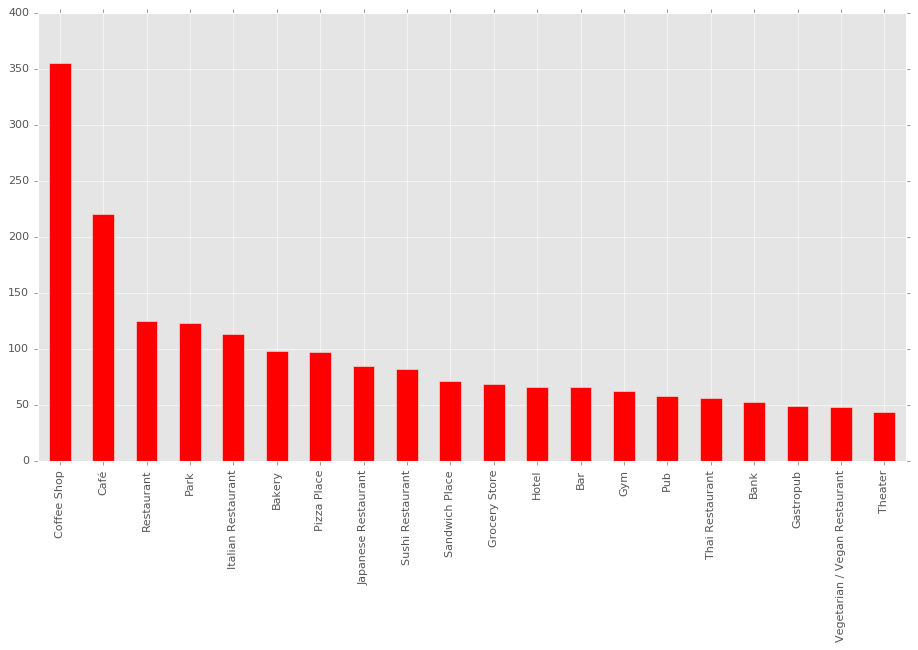

In [539]:

cluster4 = test.groupby('Cluster Labels').sum().iloc[4]
cluster4_20 = cluster4.sort_values(ascending =False).iloc[:20]

ax4 = cluster4_20.plot(kind='bar', color =rainbow[4], figsize=(14,7))

C:\Users\SteelSeries\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\SteelSeries\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\SteelSeries\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\SteelSeries\Anaconda3\lib\site-package

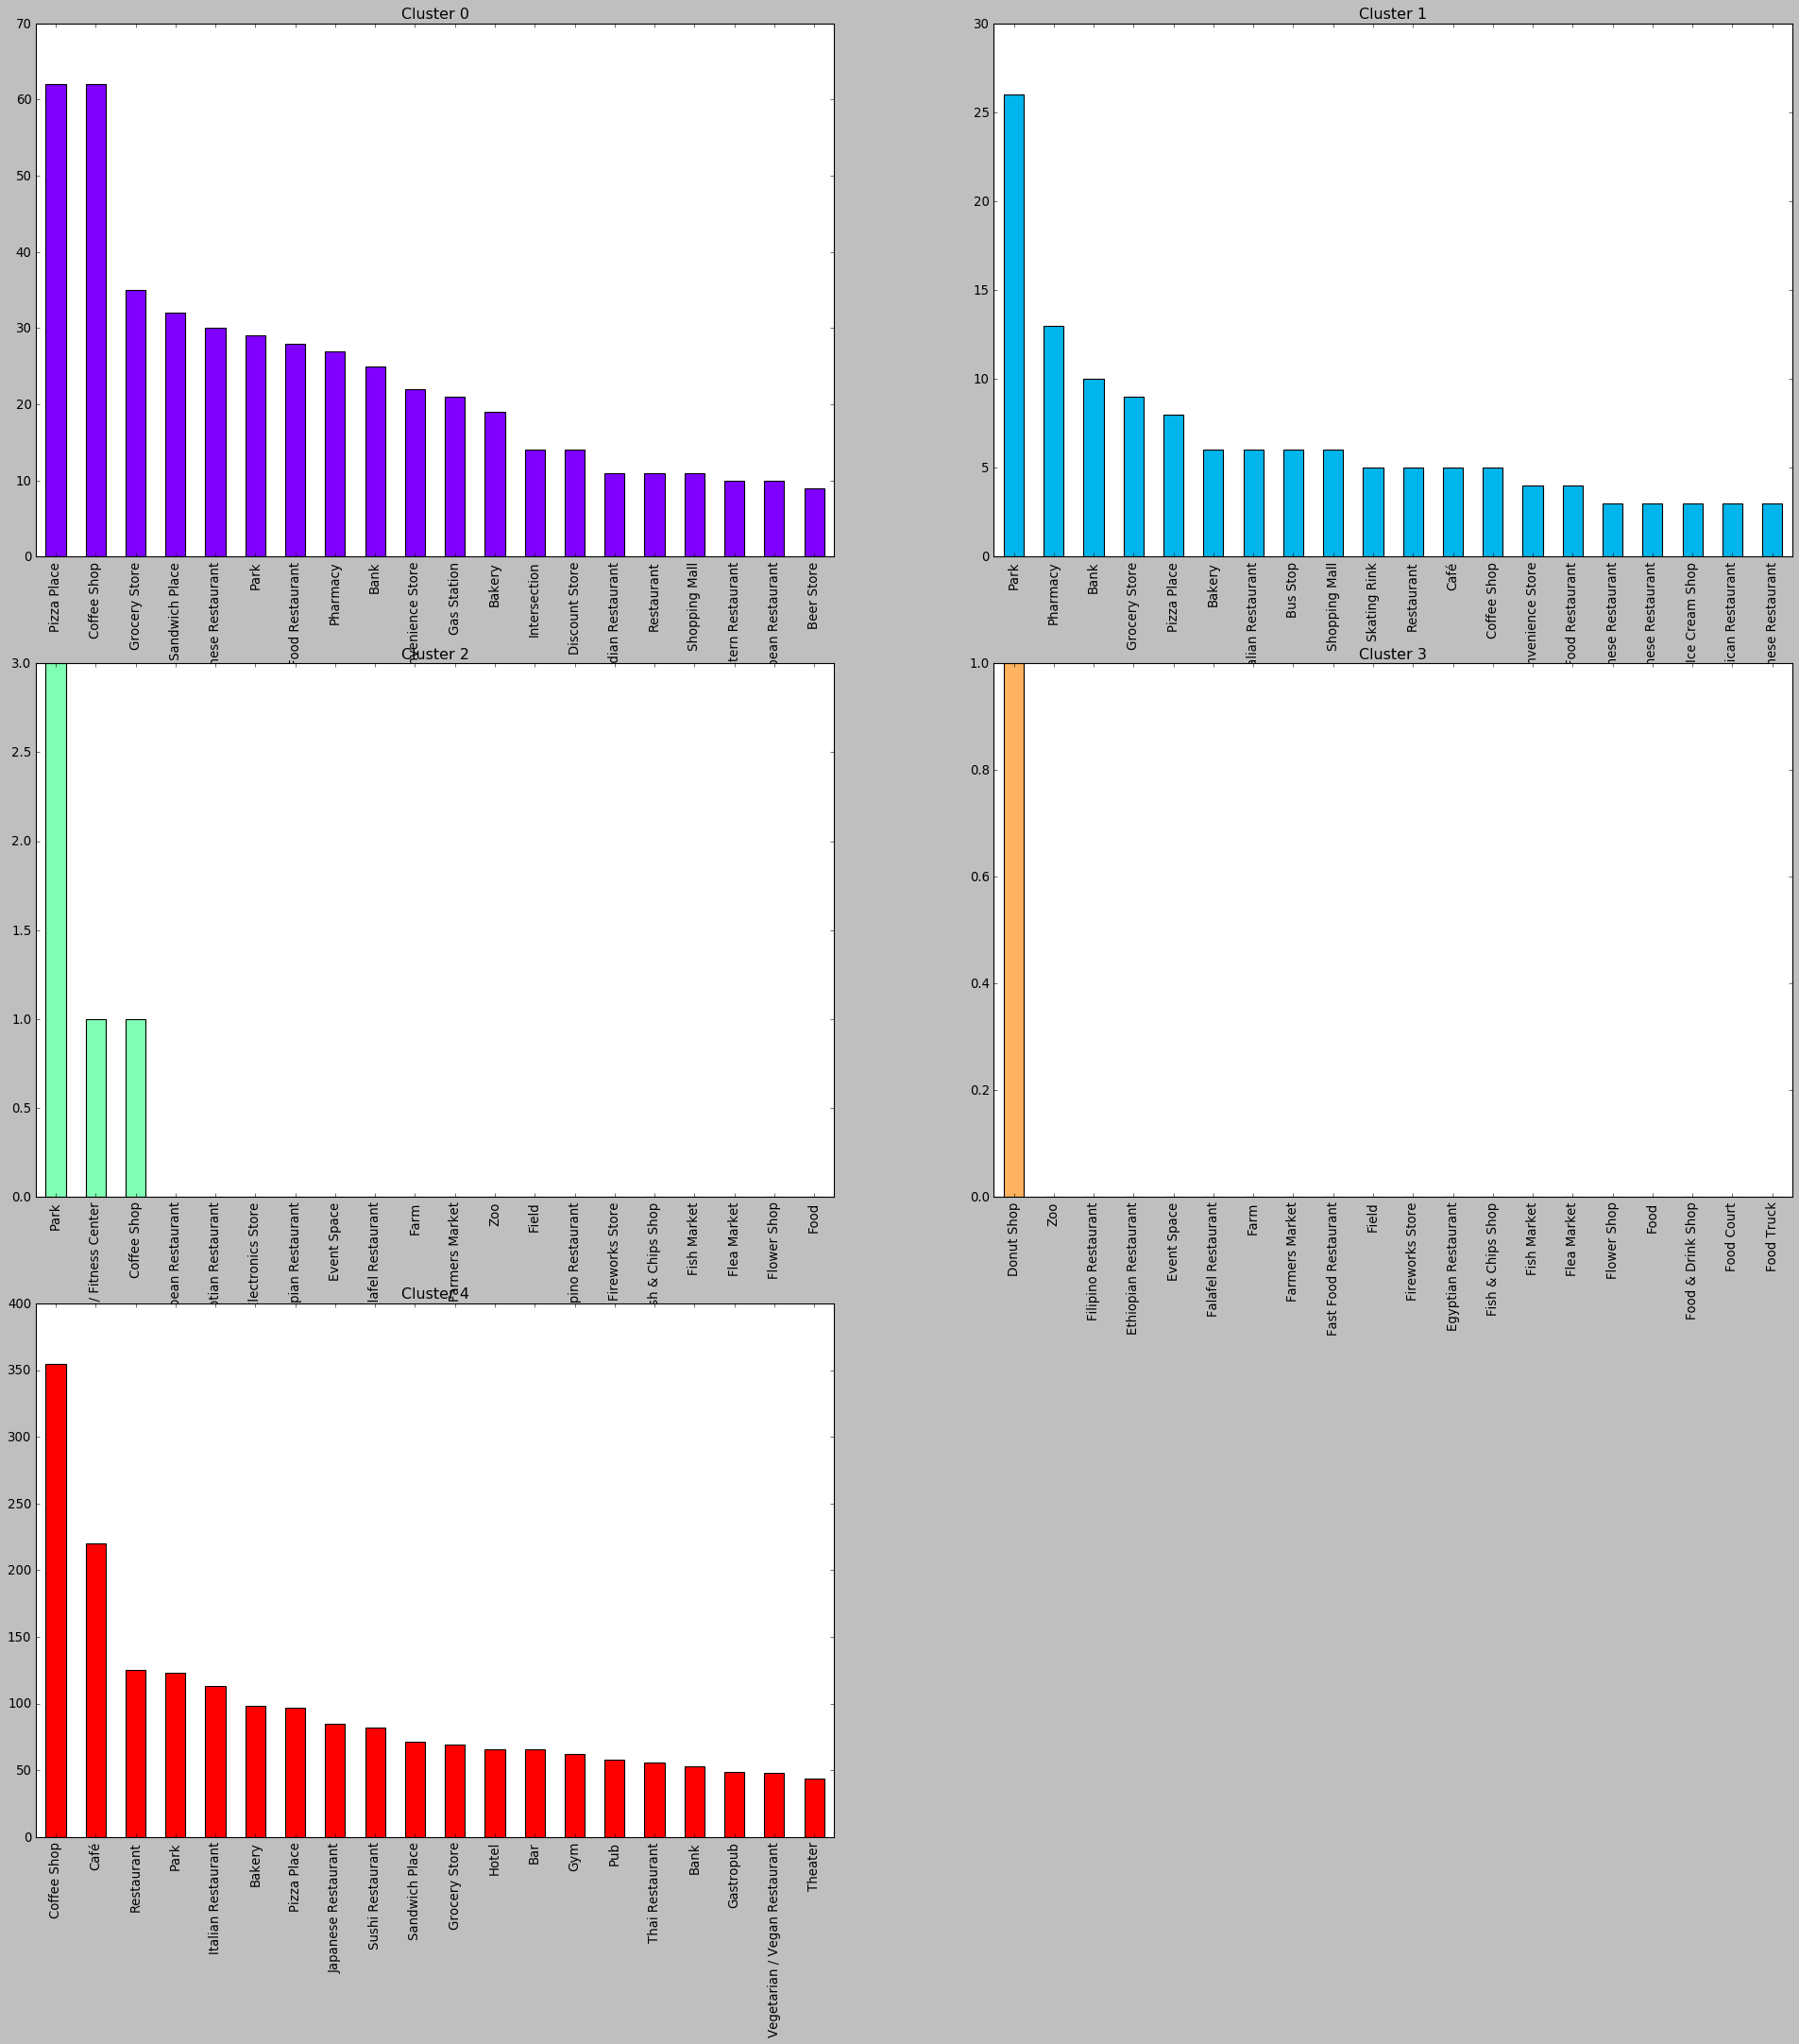

In [572]:
mpl.style.use(mpl.style.available[9])
clusters = [ cluster0_20,cluster1_20,cluster2_20,cluster3_20,cluster4_20]
title = ['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3','Cluster 4']

fig=plt.figure(figsize=(30,30))
columns = 2
rows = 3

# plot counter

for count in range(1, 6):
    fig.add_subplot(rows, columns, count)
    clusters[count-1].plot.bar(color = rainbow[count-1], title =title[count-1])
    
    plt.tight_layout

From the above plot . It is easier to visualize the composition of venues in each neighborhood.
We can infer that Neighborhoods in :
cluster0  is composed manly of food venues and recreational center

cluster1 is composed mainly of parks , Pharmacies ,Banks as well as recreational centres.

cluster2 is composed of very few venues having only few parks and gyms 

cluste3  is composed of even fewer venues with only a single donut shop.

cluster4 iscomposed of a high number of coffee shops,cafes and restaurant as well as few other venues